# Les differents types de système de recommandation:

# Introduction:

# Nettoyage des données:

In [2]:
import pandas as pd 
import numpy as np
import random
random.seed(9001)
#pour avoir toujours les memes erreurs à chaque fois qu'on re exécute le projet.

In [4]:
useri,frequsers=np.unique(tab.User_ID,return_counts=True)#useri les id des users, frequsers les freq de chaque user
itemi,freqitems=np.unique(tab.Item_ID,return_counts=True)#itemi les id des item, freqitem les freq de chaque item
n_users=len(useri)
n_items=len(itemi)
print("le nombre des utilisateurs est :"+ str(n_users) + " Et le nombre des items est: "+ str(n_items))

le nombre des utilisateurs est :730 Et le nombre des items est: 6373


In [5]:


indice_user = pd.DataFrame()
indice_user["indice"]=range(1,len(useri)+1)
indice_user["useri"]=useri


indice_item = pd.DataFrame()
indice_item["indice"]=range(1,len(itemi)+1)
indice_item["itemi"]=itemi

In [6]:
#créer user_ID_new et Item_ID_new
x=[]
y=[]
for i in range(0,len(tab)):
    x.append((indice_user.indice[indice_user.useri==tab.User_ID[i]].axes[0]+1)[0])
    y.append((indice_item.indice[indice_item.itemi==tab.Item_ID[i]].axes[0]+1)[0])


In [7]:
tab["User_ID_new"]=x
tab["Item_ID_new"]=y


In [8]:


from sklearn import cross_validation as cv
train_data, test_data = cv.train_test_split(tab[["User_ID_new","Item_ID_new","rating"]], test_size=0.25,random_state=123)

In [10]:
sparsity=round(1.0-len(tab)/float(n_users*n_items),3)
print 'The sparsity level of our data base is ' +  str(sparsity*100) + '%'

The sparsity level of our data base is 97.9%


# 1.le Memory based Collaboratif Filtering:

### 1.1 La mise en place du modèle:

In [12]:

train_data_matrix = np.zeros((n_users, n_items))#matrice nulle de longuer tous les users et tous les items
for line in train_data.itertuples():#parcourire la ligne col par col
    train_data_matrix[line[1]-1, line[2]-1] = line[3] 

test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

In [13]:
#calcule de la cos similarity : (construction du modèle)
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')
user_similarity1 = pairwise_distances(train_data_matrix, metric='cityblock')
item_similarity1 = pairwise_distances(train_data_matrix.T, metric='cityblock')


In [14]:
def predict(ratings, similarity, type='user'):#prend
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)#mean pour chauqe utilisateur (type = float)
        #np.newaxis pour convertir mean_user_rating de array de float en array d'array pour l'utiliser avec ratings
        #puis on a normalisé la var ratings (rating - E)
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) #(type === array comme la var rating)
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)]) 
        
    x = np.zeros((n_users, n_items))
    for i in range(0,n_items):
        a=max(pred[:,i])
        b=min(pred[:,i])
        c=0
        d=5
        for j in range(0,n_users):
            x[j,i]=(pred[:,i][j]-(a-c))*d/(b-a+c)
    
    return x

In [15]:
#la prédiction avec les differents modèles:
item_prediction = predict(test_data_matrix, item_similarity, type='item')
user_prediction = predict(test_data_matrix, user_similarity, type='user')
item_prediction1 = predict(test_data_matrix, item_similarity1, type='item')
user_prediction1 = predict(test_data_matrix, user_similarity1, type='user')

### 1.2. La comparaison des RMSE:

In [16]:
#la creation de la fonction qui calcule le RMSE:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth): #Root Mean Squared Error
    prediction = prediction[ground_truth.nonzero()].flatten() 
    #.flatten() fusionne les elts des array en un array
    #on attribue a prediction, les résultats des prédictions où on connait le vrais rating cad:
    #prediction: tous nos prédictions sur test; ground_truth.nonzero():les vrais résultats qu'on a dans test
    #on va mettre dans prediction les valeurs qu'on a prédit pour les elts qu'on adéja.
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()#pareil dans ground truth
    return sqrt(mean_squared_error(prediction, ground_truth))

In [17]:
print 'User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix))
print 'Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix))
print 'User-based1 CF RMSE: ' + str(rmse(user_prediction1, test_data_matrix))
print 'Item-based1 CF RMSE: ' + str(rmse(item_prediction1, test_data_matrix))


User-based CF RMSE: 1.49898656802
Item-based CF RMSE: 1.5177273779
User-based1 CF RMSE: 1.49841259116
Item-based1 CF RMSE: 1.46078749628


"\nLe meilleur mod\xc3\xa8le est celui qui a le RMSE le plus petit \nPour notre cas c'\xc3\xa9tait Item based pour la m\xc3\xa9trique cityblock.\n"

### 1.3 Simple comparaison des résultats prédits:

In [18]:
#comparaison des prediction de modele  user avec l'oeil:
R = pd.DataFrame(test_data_matrix)
R_pred=pd.DataFrame(predict(test_data_matrix, item_similarity1, type='item'))
# Compare true ratings of item 17 with predictions
ratings = pd.DataFrame(data=R.T.loc[16,R.T.loc[16,:] > 0]).head(n=10)
ratings['Prediction'] = R_pred.T.loc[16,R.T.loc[16,:] > 0]
ratings.columns = ['Actual Rating', 'Predicted Rating']
ratings

,Actual Rating,Predicted Rating
9,4.0,4.613519
35,5.0,4.741223
36,5.0,4.609985
64,4.0,3.645600
87,4.0,3.529132
128,2.0,2.876081
137,5.0,4.932248
150,3.0,4.789426
161,5.0,4.788021
165,5.0,4.730687


### 1.4 La généralisation de notre meilleur modèle:

In [19]:

#creation du modèle finale:
data_matrix = np.zeros((n_users, n_items))
for line in tab[["User_ID_new","Item_ID_new","rating"]].itertuples():#parcourire la ligne col par col
    data_matrix[line[1]-1, line[2]-1] = line[3] 
R = pd.DataFrame(data_matrix)
model_user = pairwise_distances(R, metric='cityblock')#meilleur modèle item-citoyblock .T psk c'est item
model_item = pairwise_distances(R.T, metric='cityblock')#meilleur modèle item-citoyblock .T psk c'est item

R_pred_us=pd.DataFrame(predict(data_matrix, model_user, 'user'))#la prediction
R_pred_it=pd.DataFrame(predict(data_matrix, model_item, 'item'))#la prediction


In [20]:
def getrecom_membased_for_user( iduser,n=10,ch="all"):
    estim=R_pred_us.loc[iduser-1,R.loc[iduser-1,:] == 0]
    donne=R.loc[iduser-1,R.loc[iduser-1,:] > 0]
    if ch=="discover":
        res=estim
    else:
        res=estim.append(donne)
    res=res.sort_values( ascending=False)[0:n]
    return res

In [21]:
def getrecom_membased_for_item( iditem,n=10,ch="all"):
    estim=R_pred_it.T.loc[iditem-1,R.T.loc[iditem-1,:] == 0]
    donne=R.T.loc[iditem-1,R.T.loc[iditem-1,:] > 0]
    if ch=="discover":
        res=estim
    else:
        res=estim.append(donne)
    res=res.sort_values( ascending=False)[0:n]
    return res

In [23]:
(getrecom_membased_for_item(6373,10,"all"))

40     5.000000
117    4.998489
663    4.994203
24     4.985279
84     4.982837
495    4.957466
710    4.955156
532    4.951005
426    4.939143
225    4.934024
Name: 6372, dtype: float64

In [24]:
(getrecom_membased_for_user(730,10,"discover"))#correcte!

2139    4.911902
1910    4.910203
1591    4.900214
2457    4.894726
3574    4.888690
2522    4.884848
2235    4.882589
813     4.881029
1773    4.879601
1112    4.879552
Name: 729, dtype: float64

# 2. Model-based Collaborative Filtering

## 2.1 Singular value decomposition (SVD)

### 2.1.1 La mise en place des SVD:

In [25]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

#Obtenir les composantes de SVD à partir de la matrice User-Item du train. On choisit une valeur de k=20.
u, s, vt = svds(train_data_matrix, k = 20)
s_diag_matrix=np.diag(s)

In [26]:
# Multiplication des 3 matrices avec np.dot pour obtenir la matrice User_Item estimée.
X_pred = np.dot(np.dot(u, s_diag_matrix), vt) 

In [27]:
#la normalisation de X_pred vu qu'elle retourne des données qui sont pas bien distribué dans [0,5]
import math
x = np.zeros((n_users, n_items))
for i in range(0,n_items):
    a=max(X_pred[:,i])
    b=min(X_pred[:,i])
    c=0
    d=5
    for j in range(0,n_users):
        x[j,i]=(X_pred[:,i][j]-(a-c))*d/(b-a+c)
        if math.isnan(x[j,i]): x[j,i]=0

In [28]:
# Calcul de performance avec RMSE entre la matrice estimée et la matrice du test
print 'RMSE: ' + str(rmse(x, test_data_matrix))
#On a trouvé 1.49 comme RMSE, c'est plus grand que le RMSE des modèles Memory based, mais ça prend énormement moins du temps.
#Ce qu'on va dans la partie qui suit c'est d'améliorer notre modèle par le gradient stochastique et l'ALS.

RMSE: 1.49099012467


### 2.1.2. La généralisation du modele:

In [29]:
#Après avoir implementer et tester notre modele, nous avons implémenté la fonction getrecom_membased() qui permet de recommander des items 
#à un utilisateur. 
#créant le modèle sur tout le jeu des données:
u, s, vt = svds(data_matrix, k = 20)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt) 
import math
x = np.zeros((n_users, n_items))
for i in range(0,n_items):
    a=max(X_pred[:,i])
    b=min(X_pred[:,i])
    c=0
    d=5
    for j in range(0,n_users):
        x[j,i]=(X_pred[:,i][j]-(a-c))*d/(b-a+c)
        if math.isnan(x[j,i]): x[j,i]=0
        

In [30]:
x=pd.DataFrame(x)

In [31]:

def getrecom_modbased_svd( iduser,n=10,ch="all"):
    estim=x.loc[iduser-1,R.loc[iduser-1,:] == 0]#x:la matrice qu'on a prédit
    donne=R.loc[iduser-1,R.loc[iduser-1,:] > 0]#R: la matrice qui contient les données sur tout le modèle
    if ch=="discover":
        res=estim
    else:
        res=estim.append(donne)
    res=res.sort_values( ascending=False)[0:n]
    return res


In [32]:
#recommander l'utilisateur 18 en prenons en compte tous les items y compris ceux qu'il a déjà noté. Afficher les 10 premiers résultats
getrecom_modbased_svd(80,10,"all")

103     5.0
2131    5.0
2183    5.0
2187    5.0
2401    5.0
2457    5.0
2633    5.0
3956    5.0
2814    5.0
2863    5.0
Name: 79, dtype: float64

In [33]:
#recommander l'utilisateur 18 en prenons en compte que les items qu'il n'a pas noté. Afficher les 10 premiers résultats
getrecom_modbased_svd(18,10,"discover")

4527    5.000000
2626    5.000000
2573    5.000000
2991    5.000000
1523    5.000000
2344    4.972864
3070    4.948688
2701    4.947056
2436    4.941400
4148    4.937904
Name: 17, dtype: float64

## 2.2 Stochastic Gradient Descent with Weighted Lambda Regularisation (SGD-WR)

### 2.2.1. La mise en place du modèle:

In [35]:
#Les matrices I et I2 serviront de matrices de sélecteur pour prendre les éléments appropriés après la création du Train et du Test
#selecteur de var est égal à 1 si la valeur dans la matrice est != 0

# matrice d'indices pour le train
I = train_data_matrix.copy()
I[I > 0] = 1
I[I == 0] = 0

# matrice d'indices pour le test
I2 = test_data_matrix.copy()
I2[I2 > 0] = 1
I2[I2 == 0] = 0

In [36]:
# La fonction prediction permet de prédire les ratings inconnus en multipliant les matrices P et la transposée de Q
def prediction(P,Q):
    return np.dot(P.T,Q)

In [37]:

# ****** Initialisation ******* 

lmbda = 0.1 # Terme de régularisation
k = 20 # dimension de l'espace des caractères cachés
m, n = train_data_matrix.shape  # nombre d'utilisateurs et d'items
steps = 150  # Nombre d'itération 
gamma=0.001  # vitesse d'apprentissage

P = 3 * np.random.rand(k,m) # Matrice des caractères cachés pour les utilisateurs
Q = 3 * np.random.rand(k,n) # Matrice des caractères cachés pour les items

#les matrices P et Q sont initialisées avec des valeurs aléatoires au début, mais leur contenu change à chaque itération en se 
#basant sur le train

In [43]:
""" Il existe plusieurs métriques d'évaluation, mais la plus populaire des métriques utilisée pour évaluer l'exactitude des ratings prédits
est l'erreur quadratique moyenne (RMSE) qu'on a utilisé dans notre projet :

RMSE =RacineCarrée{(1/N) * sum (r_i -estimé{r_i})^2}
"""

def rmse2(I,R,Q,P):
    return np.sqrt(np.sum((I * (R - prediction(P,Q)))**2)/len(R[R > 0]))

#R = train_data_matrix
#prediction(P,Q): estimateur du train_data_matrix avec la méthode de factorisation
#I pour prendre seulement la partie significative de la matrice (!=0)

In [44]:
#On ne considère que les valeurs !=0 
users,items = train_data_matrix.nonzero()  

In [45]:
#implémentation de the SGD-WR: (ps) cet algo prend du temps ça depend de nombre steps choisi.
train_errors = [] #stocker les erreurs du train obtenus par RMSE à chaque itération (step) 
test_errors = [] #stocker les erreurs du test obtenus par RMSE à chaque itération (step) 
     
for step in xrange(steps):
    for u, i in zip(users,items): #zip() retourne les tuples (user,item)
        e = train_data_matrix[u, i] - prediction(P[:,u],Q[:,i])  # calculer l'erreur e pour le gradient
        P[:,u] += gamma * ( e * Q[:,i] - lmbda * P[:,u]) # mise à jour de la matrice P
        Q[:,i] += gamma * ( e * P[:,u] - lmbda * Q[:,i])  # mise à jour de la matrice Q
        
    train_rmse = rmse2(I,train_data_matrix,Q,P) # Calcul de l'RMSE à partir du train
    test_rmse = rmse2(I2,test_data_matrix,Q,P) # Calcul de l'RMSE à partir du test
    train_errors.append(train_rmse) #à chaque itération ajouter l'erreur à la liste
    test_errors.append(test_rmse) #à chaque itération ajouter l'erreur à la liste



In [46]:
print 'RMSE : ' + str(np.mean(test_errors)) #RMSE = 1.18 ce qui est super! en le comparant avec les autre RMSE (1.5)

RMSE : 1.18244470872


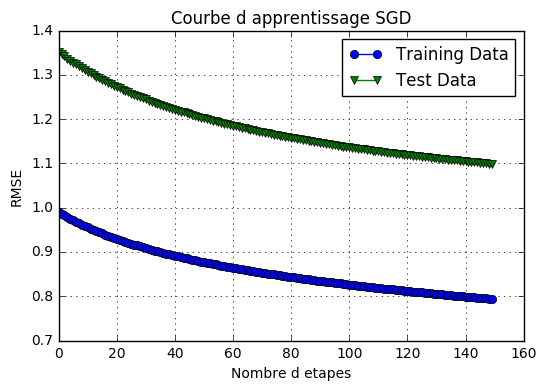

In [47]:
# Maitenant, après avoir obtenus toutes les valeurs de l'erreur à chaque étape,on peut tracer la courbe d'apprentissage.
# ==> On Vérifie la performance en traçant les erreurs du train et du test

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(steps), train_errors, marker='o', label='Training Data'); 
plt.plot(range(steps), test_errors, marker='v', label='Test Data');
plt.title('Courbe d apprentissage SGD')
plt.xlabel('Nombre d etapes');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

In [ ]:
"""
Le modèle semble fonctionner bien avec,relativement, une basse valeur de RMSE après convergence.
La performance du modèle peut dépendre des paramètres (gamma), (lambda) et k qu'on a varié à plusieurs reprises afin d'obtenir 
le meilleur RMSE.

Après cette étape, on peut comparer le rating réel avec le rating estimé; Pour ce faire, on utilise la matrice User-item qu'on a 
déjà calculée et utilisé la fonction prediction(P,Q) implémentée précédemment. 

"""

### 2.2.2 La généralisation de ce modèle:

In [57]:
import math
random.seed(123)
P = 3 * np.random.rand(k,m) 
Q = 3 * np.random.rand(k,n)
train_errors = [] 
test_errors = []
for step in xrange(steps):
    for u, i in zip(users,items): #zip() retourne les tuples (user,item)
        e = data_matrix[u, i] - prediction(P[:,u],Q[:,i])  # calculer l'erreur e pour le gradient
        P[:,u] += gamma * ( e * Q[:,i] - lmbda * P[:,u]) # mise à jour de la matrice P
        Q[:,i] += gamma * ( e * P[:,u] - lmbda * Q[:,i]) 






In [61]:
R_pred=prediction(P,Q)
x = np.zeros((n_users, n_items))
for i in range(0,n_items):
    a=max(R_pred[:,i])
    b=min(R_pred[:,i])
    c=0
    d=5
    for j in range(0,n_users):
        x[j,i]=(R_pred[:,i][j]-(a-c))*d/(b-a+c)
        if math.isnan(x[j,i]): x[j,i]=0
            


In [64]:
#Recommander des items pour un utilisateur donné:
x=pd.DataFrame(x)
def getrecom_modbased_sgd( iduser,n=10,ch="all" ):
    estim=x.loc[iduser-1,R.loc[iduser-1,:] == 0]
    donne=R.loc[iduser-1,R.loc[iduser-1,:] > 0]
    if ch=="discover":
        res=estim
    else:
        res=estim.append(donne)
    res=res.sort_values( ascending=False)[0:n]
    return res

In [65]:
#recommander l'utilisateur 18 en prenons en compte tous les items y compris ceux qu'il a déjà noté. Afficher les 10 premiers résultats
getrecom_modbased_sgd(18,10,"all")

855     5.0
202     5.0
942     5.0
225     5.0
1029    5.0
866     5.0
1042    5.0
204     5.0
1053    5.0
255     5.0
Name: 17, dtype: float64

In [66]:
#recommander l'utilisateur 18 en prenons en compte que les items qu'il n'a pas noté. Afficher les 10 premiers résultats
getrecom_modbased_sgd(18,10,"discover")

5902    4.649808
3246    4.625329
572     4.615001
4167    4.592095
2219    4.590571
5562    4.588044
4481    4.586026
3240    4.578914
5164    4.578659
2440    4.574947
Name: 17, dtype: float64

##  2.3. Non-Negative Matrix Factorization (NMF)

In [ ]:
""" 
Nous restons ici dans le deuxième sous-type du fitrage collaboratif : "Model-based"en utilisant la matrice de factorisation.
Mais cette fois-ci nous utilisons NMF (Non-Negative Matrix Factorization) de sklearn pour l'appliquer

"""

In [76]:
#Utilisation de la fonction NMF de sklearn. Ajustement du modèle avec le Train
from sklearn.decomposition import NMF
nmf_model = NMF(n_components=5, init='random', random_state=0)
nmf_model.fit(train_data_matrix)

NMF(alpha=0.0, beta=1, eta=0.1, init='random', l1_ratio=0.0, max_iter=200,
  n_components=5, nls_max_iter=2000, random_state=0, shuffle=False,
  solver='cd', sparseness=None, tol=0.0001, verbose=0)

In [96]:
#Obtention des matrices P et Q(Transposée) à partir du Test 
P = nmf_model.transform(test_data_matrix);
Q_T = nmf_model.components_;

#Calcul de la matrice user_item estimée en multipliant les matrice P et Q(Transposée)
nR = np.dot(P, Q_T)


In [79]:
x = np.zeros((n_users, n_items))
for i in range(0,n_items):
    a=max(nR[:,i])
    b=min(nR[:,i])
    c=0
    d=5
    for j in range(0,n_users):
        x[j,i]=(nR[:,i][j]-(a-c))*d/(b-a+c)
        if math.isnan(x[j,i]): x[j,i]=0

In [80]:
rmse(x, test_data_matrix)

1.7395234803101045

## 2.4 Alternating Least Squares

In [125]:
# Index matrix for training data
I = train_data_matrix.copy()
I[I > 0] = 1
I[I == 0] = 0

# Index matrix for test data
I2 = test_data_matrix.copy()
I2[I2 > 0] = 1
I2[I2 == 0] = 0

In [132]:
#ps: on n'a pas commenté car c'est presque le mm principe que le modele SGD!
lmbda = 0.1 
k = 20 
n_epochs = 2 # Nombre d'étapes
m, n = train_data_matrix.shape # Number of users and items
P = 3 * np.random.rand(k,m) # Latent user feature matrix
Q = 3 * np.random.rand(k,n) # Latent item feature matrix
Q[0,:] = train_data_matrix[train_data_matrix != 0].mean(axis=0) # Avg. rating for each movie
E = np.eye(k) # (k x k)-dimensional idendity matrix

In [133]:
data_matrix.shape

(730L, 6373L)

In [134]:
train_errors = []
test_errors = []

# Repeat until convergence
for epoch in range(n_epochs):
    # Fix Q and estimate P
    for i, Ii in enumerate(I):
        nui = np.count_nonzero(Ii) # Number of items user i has rated
        if (nui == 0): nui = 1 # Be aware of zero counts!
    
        # Least squares solution
        Ai = np.dot(Q, np.dot(np.diag(Ii), Q.T)) + lmbda * nui * E
        Vi = np.dot(Q, np.dot(np.diag(Ii), train_data_matrix[i].T))
        P[:,i] = np.linalg.solve(Ai,Vi)
        
    # Fix P and estimate Q
    for j, Ij in enumerate(I.T):
        nmj = np.count_nonzero(Ij) # Number of users that rated item j
        if (nmj == 0): nmj = 1 # Be aware of zero counts!
        
        # Least squares solution
        Aj = np.dot(P, np.dot(np.diag(Ij), P.T)) + lmbda * nmj * E
        Vj = np.dot(P, np.dot(np.diag(Ij), train_data_matrix[:,j]))
        Q[:,j] = np.linalg.solve(Aj,Vj)
    
    train_rmse = rmse2(I,train_data_matrix,Q,P)
    test_rmse = rmse2(I2,test_data_matrix,Q,P)
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)
    
    print "[Epoch %d/%d] train error: %f, test error: %f" \
    %(epoch+1, n_epochs, train_rmse, test_rmse)
    
print "Algorithm converged"

[Epoch 1/2] train error: 1.064051, test error: 1.305094
[Epoch 2/2] train error: 0.779620, test error: 1.133827
Algorithm converged
